X = [1, 2, 3, 4, 5]
Y = [2, 3, 4, 5, 6]



Dict{Symbol, Any} with 8 entries:
  :α         => 0.05
  :p         => 0.5
  :df        => 8.0
  :phat      => 0.68
  :sehat     => 0.181108
  :tvalue    => 0.993884
  :pvalue    => 0.349386
  :confint_p => (0.262365, 1.09764)


phat = 0.68
ahat = -1.0
α = 0.05
ci_p = [0.2623648885, 1.097635111]
ci_a = [-3.0, 1.0]



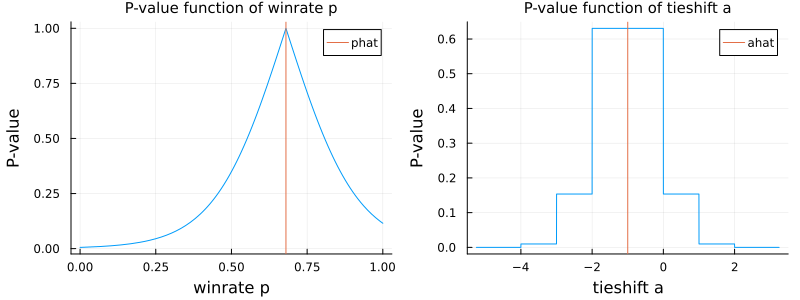

In [1]:
using Distributions
using Roots
using StatsPlots
default(fmt=:png, titlefontsize=10)

r(x) = round(x; sigdigits=10)

winrate(X, Y) = mean((x < y) + (x == y)/2 for x in X, y in Y)

function brunner_munzel_test(X, Y; p=1/2, α=0.05)
    phat = winrate(X, Y)
    m, n = length(X), length(Y)
    sx2 = 1/(m-1) * sum(x -> (mean(y -> (y < x) + (y == x)/2, Y) - (1 - phat))^2, X)
    sy2 = 1/(n-1) * sum(y -> (mean(x -> (x < y) + (x == y)/2, X) - phat)^2, Y)
    sehat = √(sx2/m + sy2/n)
    tvalue = (phat - p)/sehat
    df = (sx2/m + sy2/n)^2 / ((sx2/m)^2/(m-1) + (sy2/n)^2/(n-1))
    pvalue = sehat > 0 ? 2ccdf(TDist(df), abs(tvalue)) : phat ≈ p ? 1.0 : 0.0
    c = sehat > 0 ? cquantile(TDist(df), α/2) : 0.0
    confint_p = (phat - c*sehat, phat + c*sehat)
    (; p, phat, sehat, tvalue, df, pvalue, α, confint_p)
end

function brunner_munzel_pvalue(p, phat, sehat, df)
    tvalue = (phat - p)/sehat
    sehat > 0 ? 2ccdf(TDist(df), abs(tvalue)) : phat ≈ p ? 1.0 : 0.0
end

function confint_bm_p_roots(X, Y; α=0.05)
    f(p) = brunner_munzel_test(X, Y; p).pvalue - α
    find_zeros(f, -1, 2)
end

function aminamax(X, Y)
    xmin, xmax = extrema(X)
    ymin, ymax = extrema(Y)
    width = max(xmax, ymax) - min(xmin, ymin)
    xmin - ymax - max(0.1, 0.05width), xmax - ymin + max(0.1, 0.05width)
end

function tieshift(X, Y; p=1/2)
    f(a) = winrate(X, Y .+ a) - p
    amin, amax = aminamax(X, Y)
    find_zero(f, (amin, amax))
end

function confint_bm_tieshift(X, Y; α=0.05)
    f(a) = brunner_munzel_test(X, Y .+ a).pvalue - α
    amin, amax = aminamax(X, Y)
    find_zeros(f, amin, amax)
end

X = [1, 2, 3, 4, 5]
Y = [2, 3, 4, 5, 6]
@show X Y
println()

bm = brunner_munzel_test(X, Y)
display(bm |> pairs |> Dict)
println()

phat = bm.phat |> r
ahat = tieshift(X, Y) |> r
@show phat ahat
α = bm.α
ci_p = collect(bm.confint_p) .|> r
ci_a = confint_bm_tieshift(X, Y; α) .|> r
@show α ci_p ci_a
#@show confint_bm_p_roots(X, Y; α) .|> r
println()

P = plot(p -> brunner_munzel_pvalue(p, bm.phat, bm.sehat, bm.df), 0, 1; label="")
vline!([phat]; label="phat")
plot!(xguide="winrate p", yguide="P-value")
title!("P-value function of winrate p")

amin, amax = aminamax(X, Y)
Q = plot(a -> brunner_munzel_test(X, Y .+ a).pvalue, amin, amax; label="")
vline!([ahat]; label="ahat")
plot!(xguide="tieshift a", yguide="P-value")
title!("P-value function of tieshift a")

plot(P, Q; size=(800, 300))
plot!(leftmargin=4Plots.mm, bottommargin=4Plots.mm)

https://x.com/ppubmed/status/1838333246456918364

```
{
  "statistic": 0.9938837346736192,
  "df": 8,
  "pValue": 0.3493862420992859,
  "estimate": 0.68,
  "ci": [
    0.26236488884807324,
    1.097635111151927
  ],
  "confLevel": 0.95
}
```

In [2]:
using RCall
@rput X Y
R"wilcox.test(X, Y, conf.int=T)"

┌ Warning: RCall.jl: Warning in wilcox.test.default(X, Y, conf.int = T) :
│   cannot compute exact p-value with ties
│ Warning in wilcox.test.default(X, Y, conf.int = T) :
│   cannot compute exact confidence intervals with ties
└ @ RCall D:\.julia\packages\RCall\0ggIQ\src\io.jl:172


RObject{VecSxp}

	Wilcoxon rank sum test with continuity correction

data:  X and Y
W = 8, p-value = 0.3976
alternative hypothesis: true location shift is not equal to 0
95 percent confidence interval:
 -3.99997  1.99997
sample estimates:
difference in location 
                    -1 



Dict{Symbol, Any} with 8 entries:
  :α         => 0.05
  :p         => 0.5
  :df        => 15.8917
  :phat      => 0.24
  :sehat     => 0.115854
  :tvalue    => -2.2442
  :pvalue    => 0.0394203
  :confint_p => (-0.00573633, 0.485736)


ahat = 0.2639369629
ci_a = [0.0059, 0.501]


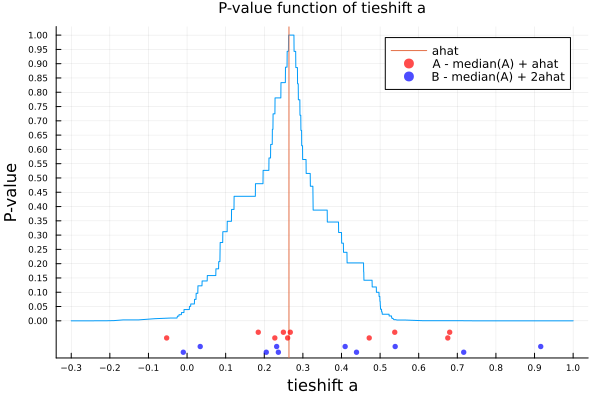

In [3]:
A = [0.9753, 0.9802, 0.2471, 0.8379, 0.5673, 0.7718, 0.5273, 0.5605, 0.4844, 0.5495]
B = [0.9521, 0.4455, 0.0263, 0.4749, 0.2681, 0.7526, 0.0701, 0.2725, 0.2412, 0.5751]
brunner_munzel_test(A, B) |> pairs |> Dict |> display
println()

#amin, amax = aminamax(A, B)
amin, amax = -0.3, 1.0
ahat = tieshift(A, B) |> r
ci_a = confint_bm_tieshift(A, B) .|> r
@show ahat ci_a
Q = plot(a -> brunner_munzel_test(A, B .+ a).pvalue, amin, amax; label="")
vline!([ahat]; label="ahat")
scatter!(sort(A) .- median(A) .+ ahat, -0.05 .+ 0.01*(-1).^(1:length(A));
    label="A - median(A) + ahat", c=:red,  msc=:auto, ma=0.7, ms=3)
scatter!(sort(B) .- median(A) .+ 2ahat, -0.10 .+ 0.01*(-1).^(1:length(B));
    label="B - median(A) + 2ahat", c=:blue, msc=:auto, ma=0.7, ms=3)
plot!(xguide="tieshift a", yguide="P-value")
plot!(xtick=-1:0.1:1, ytick=0:0.05:1, tickfontsize=6)
plot!(ylim=(-0.13, 1.03))
title!("P-value function of tieshift a")

In [4]:
using RCall
@rput A B
R"wilcox.test(A, B, conf.int=T)"

RObject{VecSxp}

	Wilcoxon rank sum exact test

data:  A and B
W = 76, p-value = 0.05243
alternative hypothesis: true location shift is not equal to 0
95 percent confidence interval:
 -0.0078  0.5053
sample estimates:
difference in location 
                0.2699 

